<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/CNN_2_classes_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/Виноградники/Dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Dataset/train/2/frame_421.jpg  
  inflating: Dataset/train/2/frame_423.jpg  
  inflating: Dataset/train/2/frame_425.jpg  
  inflating: Dataset/train/2/frame_426.jpg  
  inflating: Dataset/train/2/frame_427.jpg  
  inflating: Dataset/train/2/frame_43.jpg  
  inflating: Dataset/train/2/frame_46.jpg  
  inflating: Dataset/train/2/frame_47.jpg  
  inflating: Dataset/train/2/frame_48.jpg  
  inflating: Dataset/train/2/frame_49.jpg  
  inflating: Dataset/train/2/frame_5.jpg  
  inflating: Dataset/train/2/frame_50.jpg  
  inflating: Dataset/train/2/frame_51.jpg  
  inflating: Dataset/train/2/frame_52.jpg  
  inflating: Dataset/train/2/frame_53.jpg  
  inflating: Dataset/train/2/frame_54.jpg  
  inflating: Dataset/train/2/frame_55.jpg  
  inflating: Dataset/train/2/frame_57.jpg  
  inflating: Dataset/train/2/frame_59.jpg  
  inflating: Dataset/train/2/frame_59138.jpg  
  inflating: Dataset/train/2/frame_59139.jpg 

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.models as models
import torch.nn as nn

In [ ]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [ ]:
plt.rcParams['figure.figsize'] = 14, 6
  

normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))])
  
#Загрузка датасета из 2 классов

train_dataset = torchvision.datasets.ImageFolder(root = '/content/Dataset/train',
                                                transform = normalize_transform,
                                                is_valid_file = check_image)
    
test_dataset = torchvision.datasets.ImageFolder(root = '/content/Dataset/test',
                                                transform = normalize_transform,
                                                is_valid_file = check_image)
    
val_dataset = torchvision.datasets.ImageFolder(root = '/content/Dataset/val',
                                                transform = normalize_transform,
                                                is_valid_file = check_image)


batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    


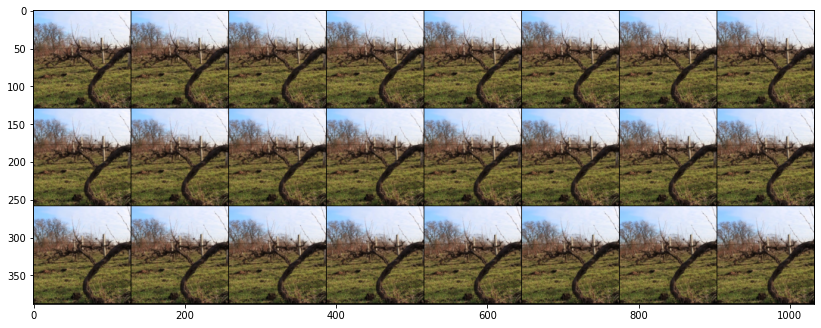

In [ ]:
#График из 25 изображений
images, labels = next(iter(train_loader))
plt.imshow(np.transpose(torchvision.utils.make_grid(images[1:25], normalize=True, padding = 1).numpy(), (1, 2, 0)))

In [ ]:
classes = []
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data 
    classes.extend(y.tolist())
      

unique, counts = np.unique(classes, return_counts=True)
names = list(test_dataset.class_to_idx.keys())
names
#plt.bar(names, counts)
#plt.xlabel("Target Classes")
#plt.ylabel("Number of training instances")

['1', '2']

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 64),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(64, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    

num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Обучение модели
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Перемещение данных на Cuda
        images = images.to(device)
        labels = labels.to(device)
        
        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Обратный ход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/20], Step [181/181], Loss: 0.0018
Epoch [2/20], Step [181/181], Loss: 0.3688
Epoch [3/20], Step [181/181], Loss: 0.4848
Epoch [4/20], Step [181/181], Loss: 0.1498
Epoch [5/20], Step [181/181], Loss: 0.4896
Epoch [6/20], Step [181/181], Loss: 0.4868
Epoch [7/20], Step [181/181], Loss: 0.4859
Epoch [8/20], Step [181/181], Loss: 0.4867
Epoch [9/20], Step [181/181], Loss: 0.4866
Epoch [10/20], Step [181/181], Loss: 0.4868
Epoch [11/20], Step [181/181], Loss: 0.4868
Epoch [12/20], Step [181/181], Loss: 0.4859
Epoch [13/20], Step [181/181], Loss: 0.4868
Epoch [14/20], Step [181/181], Loss: 0.4868
Epoch [15/20], Step [181/181], Loss: 0.4868
Epoch [16/20], Step [181/181], Loss: 0.4746
Epoch [17/20], Step [181/181], Loss: 0.4865
Epoch [18/20], Step [181/181], Loss: 0.4868
Epoch [19/20], Step [181/181], Loss: 0.4868
Epoch [20/20], Step [181/181], Loss: 0.4868


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Точность сети на {} test images: {} %'.format(len(test_dataset.imgs), 100 * correct / total))   

Точность сети на 1654 test images: 26.723095525997582 %


In [ ]:
# Обработка изображения
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((128, int(128*(height/width))) if width < height else (int(128*(width/height)), 128))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.5)/0.5
    img[1] = (img[1] - 0.5)/0.5
    img[2] = (img[2] - 0.5)/0.5
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [ ]:
k = 0.6

In [ ]:
def predict(image, model):

    if torch.cuda.is_available():
        device = torch.device("cuda") 
    else:
        device = torch.device("cpu")

    image = image.to(device)

    output = model(image)
    
    output = torch.exp(output) 

    probs, classes = output.topk(1, dim=1)

    print(output)
    return probs.item(), classes.item(), output

In [ ]:
def show_image(image):
    image = image.numpy()

    image[0] = image[0] * 0.5 + 0.5

    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [ ]:
images, labels = next(iter(val_loader))


tensor([[0.7672, 1.2871]], device='cuda:0', grad_fn=<ExpBackward0>)
tensor([[0.7672, 1.2871]], device='cuda:0', grad_fn=<ExpBackward0>)
Модель  128.71159315109253 % вероятнотью предсказала класс 1


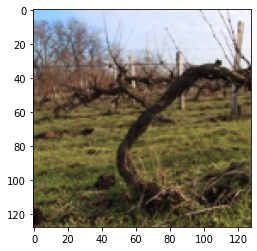

In [ ]:
image = process_image("/content/Dataset/val/1/frame_10929.jpg")
#image1 = torch.tensor([images[1]])


top_prob, top_class, output = predict(image, model) 

show_image(image)

print(output)

print("Модель ", top_prob*100, "% вероятнотью предсказала класс", top_class)